In [41]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from keras.preprocessing import image

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.metrics import precision_score, recall_score, f1_score

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
results = {}



##IsolationForest

In [43]:
# Set the directory paths for the training and testing data
train_dir = '/content/drive/MyDrive/Hazelnut/train'
test_dir = '/content/drive/MyDrive/Hazelnut/test'

# Desired dimensions of the images
img_width, img_height = 128, 128

# Read the training images and store them in a list
images = []
for file in os.listdir(os.path.join(train_dir, 'good')):
    img = cv2.imread(os.path.join(train_dir, 'good', file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_width, img_height))  # Resize image
    images.append(img)

# Convert the list of images to a numpy array and flatten
images = np.array(images).reshape(len(images), -1)

# Train the isolation forest model
model = IsolationForest(random_state=0).fit(images)

# Read the test images and store them in a list
test_images = []
test_labels = []
for subdir in ['good', 'crack']:
    for file in os.listdir(os.path.join(test_dir, subdir)):
        img = cv2.imread(os.path.join(test_dir, subdir, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (img_width, img_height))  # Resize image
        test_images.append(img)
        test_labels.append(0 if subdir == 'good' else 1)

# Convert the list of test images to a numpy array and flatten
test_images = np.array(test_images).reshape(len(test_images), -1)

# Use the trained model to predict the anomaly scores of the test images
anomaly_scores = model.decision_function(test_images)

# Evaluate the performance of the model using the anomaly scores and the true labels
if_auc_score = roc_auc_score(test_labels, -anomaly_scores)
print('AUC score isolationForest:', if_auc_score)

results['IsolationForest'] = if_auc_score





AUC score isolationForest: 0.8826666666666667


#Convolutional Neural Networks

In [44]:
# Set the directory paths for the training and testing data
train_dir = '/content/drive/MyDrive/Hazelnut/train'
test_dir = '/content/drive/MyDrive/Hazelnut/test'

# Define the input shape of the images
input_shape = (64, 64, 1)

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Read the training images and store them in a list
train_images = []
train_labels = []
for subdir in ['good', 'crack']:
    for file in os.listdir(os.path.join(train_dir, subdir)):
        img = cv2.imread(os.path.join(train_dir, subdir, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (input_shape[0], input_shape[1]))
        img = img / 255.0  # Normalize image
        img = np.expand_dims(img, axis=-1)
        train_images.append(img)
        train_labels.append(0 if subdir == 'good' else 1)

# Convert the list of images and labels to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Read the test images and store them in a list
test_images = []
test_labels = []
for subdir in ['good', 'crack']:
    for file in os.listdir(os.path.join(test_dir, subdir)):
        img = cv2.imread(os.path.join(test_dir, subdir, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (input_shape[0], input_shape[1]))
        img = img / 255.0  # Normalize image
        img = np.expand_dims(img, axis=-1)
        test_images.append(img)
        test_labels.append(0 if subdir == 'good' else 1)

# Convert the list of test images and labels to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Train the model
model.fit(train_images, train_labels, epochs=30, batch_size=32)

# Evaluate the model on the test set
loss, cnn_accuracy = model.evaluate(test_images, test_labels)
print('Test loss of CNN:', loss)
print('Test accuracy of CNN :', cnn_accuracy)

results['CNN'] = cnn_accuracy



cnn_probabilities = model.predict(test_images)
cnn_auc = roc_auc_score(test_labels, cnn_probabilities)
print('CNN AUC:', cnn_auc)

Epoch 1/30
13/13 [==============================] - 2s 7ms/step - loss: 0.4130 - accuracy: 0.8337
Epoch 2/30
13/13 [==============================] - 0s 7ms/step - loss: 0.2995 - accuracy: 0.8759
Epoch 3/30
13/13 [==============================] - 0s 7ms/step - loss: 0.1890 - accuracy: 0.8759
Epoch 4/30
13/13 [==============================] - 0s 6ms/step - loss: 0.1495 - accuracy: 0.8759
Epoch 5/30
13/13 [==============================] - 0s 6ms/step - loss: 0.1218 - accuracy: 0.8958
Epoch 6/30
13/13 [==============================] - 0s 6ms/step - loss: 0.1226 - accuracy: 0.9280
Epoch 7/30
13/13 [==============================] - 0s 6ms/step - loss: 0.1148 - accuracy: 0.9429
Epoch 8/30
13/13 [==============================] - 0s 7ms/step - loss: 0.1086 - accuracy: 0.9504
Epoch 9/30
13/13 [==============================] - 0s 6ms/step - loss: 0.1056 - accuracy: 0.9628
Epoch 10/30
13/13 [==============================] - 0s 6ms/step - loss: 0.1028 - accuracy: 0.9727
Epoch 11/30
13/13 [

#VGG16

In [45]:
# Set the random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Set the directory paths for the training and testing data
train_dir = '/content/drive/MyDrive/Hazelnut/train'
test_dir = '/content/drive/MyDrive/Hazelnut/test'

# Define the input shape of the images
input_shape = (224, 224, 3)

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add fully-connected layers on top of the pre-trained layers
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create a new model with the pre-trained layers and your own layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers so that they're not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Read the training images and store them in a list
train_images = []
train_labels = []
for subdir in ['good', 'crack']:
    for file in os.listdir(os.path.join(train_dir, subdir)):
        img = cv2.imread(os.path.join(train_dir, subdir, file))
        img = cv2.resize(img, (input_shape[0], input_shape[1]))
        img = img.astype(np.float32) / 255.0
        if img.shape[-1] == 1:
            img = np.repeat(img, 3, axis=-1)
        train_images.append(img)
        train_labels.append(0 if subdir == 'good' else 1)

# Convert the list of images and labels to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Read the test images and store them in a list
test_images = []
test_labels = []
for subdir in ['good', 'crack']:
    for file in os.listdir(os.path.join(test_dir, subdir)):
        img = cv2.imread(os.path.join(test_dir, subdir, file))
        img = cv2.resize(img, (input_shape[0], input_shape[1]))
        img = img.astype(np.float32) / 255.0
        if img.shape[-1] == 1:
            img = np.repeat(img, 3, axis=-1)
        test_images.append(img)
        test_labels.append(0 if subdir == 'good' else 1)

# Convert the list of test images and labels to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Train the model
model.fit(train_images, train_labels, epochs=30, batch_size=32)

# Evaluate the model on the test set
loss, vgg_accuracy = model.evaluate(test_images, test_labels)
print('Test loss:', loss)
print('Test accuracy:', vgg_accuracy)

results['VGG16'] = vgg_accuracy


vgg_probabilities = model.predict(test_images)
vgg_auc = roc_auc_score(test_labels, vgg_probabilities)
print('VGG16 AUC:', vgg_auc)



Epoch 1/30
13/13 [==============================] - 4s 129ms/step - loss: 0.8519 - accuracy: 0.8486
Epoch 2/30
13/13 [==============================] - 2s 119ms/step - loss: 0.2059 - accuracy: 0.8759
Epoch 3/30
13/13 [==============================] - 2s 120ms/step - loss: 0.1308 - accuracy: 0.9330
Epoch 4/30
13/13 [==============================] - 2s 120ms/step - loss: 0.1131 - accuracy: 0.9653
Epoch 5/30
13/13 [==============================] - 2s 120ms/step - loss: 0.1024 - accuracy: 0.9578
Epoch 6/30
13/13 [==============================] - 2s 120ms/step - loss: 0.0961 - accuracy: 0.9653
Epoch 7/30
13/13 [==============================] - 2s 120ms/step - loss: 0.0930 - accuracy: 0.9876
Epoch 8/30
13/13 [==============================] - 2s 123ms/step - loss: 0.0904 - accuracy: 0.9752
Epoch 9/30
13/13 [==============================] - 2s 123ms/step - loss: 0.0885 - accuracy: 0.9876
Epoch 10/30
13/13 [==============================] - 2s 123ms/step - loss: 0.0886 - accuracy: 0.9851

2/2 [==============================] - 0s 57ms/step - loss: 0.4434 - accuracy: 0.9500
Test loss: 0.44338956475257874
Test accuracy: 0.949999988079071


2/2 [==============================] - 0s 104ms/step
VGG16 AUC: 0.9946666666666667


#Illustration of correctly and incorrectly predicted images for VGG16

2/2 [==============================] - 0s 107ms/step
Correctly predicted: 38
Incorrectly predicted: 2


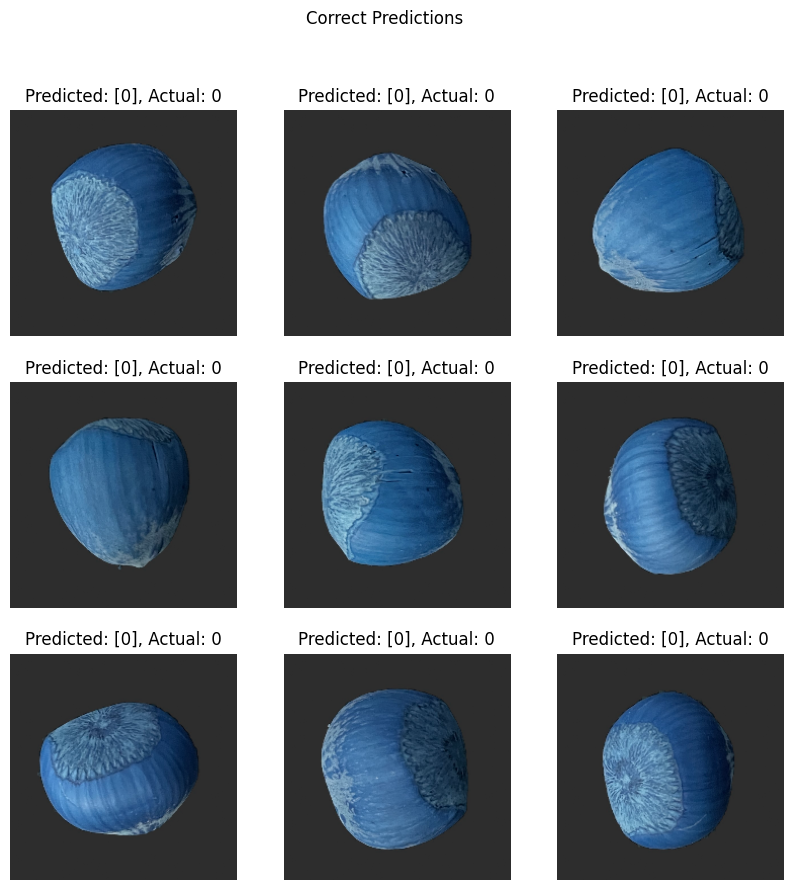

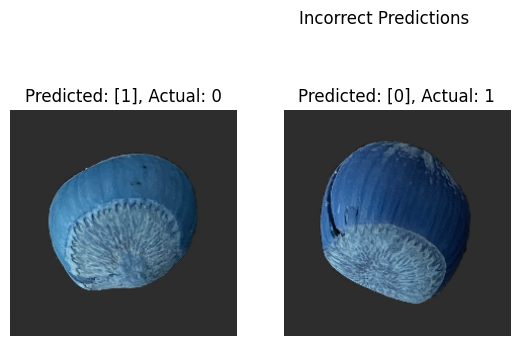

In [46]:
# Predict the labels of the test set
predicted_labels = model.predict(test_images)

# The model outputs probabilities so convert them into binary predictions
predicted_labels = (predicted_labels > 0.5).astype(int)

# Find the indices of the samples that were predicted correctly and incorrectly
correct_indices = np.where(predicted_labels.flatten() == test_labels)[0]
incorrect_indices = np.where(predicted_labels.flatten() != test_labels)[0]

# Print the number of correct and incorrect predictions
print(f"Correctly predicted: {len(correct_indices)}")
print(f"Incorrectly predicted: {len(incorrect_indices)}")

# Plot some correctly predicted images
plt.figure(figsize=(10,10))
for i, correct_idx in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[correct_idx])
    plt.title(f"Predicted: {predicted_labels[correct_idx]}, Actual: {test_labels[correct_idx]}")
    plt.axis('off')
plt.suptitle("Correct Predictions")
plt.show()

# Plot some incorrectly predicted images
plt.figure(figsize=(10,10))
for i, incorrect_idx in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[incorrect_idx])
    plt.title(f"Predicted: {predicted_labels[incorrect_idx]}, Actual: {test_labels[incorrect_idx]}")
    plt.axis('off')
plt.suptitle("Incorrect Predictions")
plt.show()


# decision trees

In [47]:
# Load the dataset
dataset_path = '/content/drive/MyDrive/Hazelnut/train'
classes = os.listdir(dataset_path)
data = []
labels = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        data.append(image)
        labels.append(class_name)

# Preprocess the images
data = [cv2.resize(image, (64, 64)).flatten() for image in data]

# Convert the list to a numpy array
data = np.array(data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.40, random_state=55)

# Train the decision tree classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy

print("Accuracy:", accuracy)



Accuracy: 0.9753086419753086


# k-means

In [48]:
# Load the dataset
dataset_path = '/content/drive/MyDrive/Hazelnut/train'
classes = os.listdir(dataset_path)
data = []
labels = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        data.append(image)
        labels.append(class_name)

# Preprocess the images
data = [cv2.resize(image, (64, 64)).flatten() for image in data]

# Convert the list to a numpy array
data = np.array(data)

# Train K-means model
kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

# Get cluster labels for the dataset
cluster_labels = kmeans.labels_

# Calculate evaluation metrics (ARI and NMI) if ground truth labels are available
ground_truth_labels = labels
ari = adjusted_rand_score(ground_truth_labels, cluster_labels)
nmi = normalized_mutual_info_score(ground_truth_labels, cluster_labels)
print("Accuracy:", accuracy)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.9753086419753086


# pca

In [49]:
# Load the dataset
dataset_path = '/content/drive/MyDrive/Hazelnut/train'
classes = os.listdir(dataset_path)
data = []
labels = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        data.append(image)
        labels.append(class_name)

# Preprocess the images
data = [cv2.resize(image, (64, 64)).flatten() for image in data]

# Convert the list to a numpy array
data = np.array(data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.4, random_state=42)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)  # Number of principal components to keep
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train SVM on the reduced feature space
svm = SVC()
svm.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test_pca)

# Compute evaluation metrics
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print confusion matrix
print('Confusion Matrix:')
print(cm)

# Print evaluation metrics
print('F1 Score:', f1)
print('Precision:', precision)
print('Recall:', recall)


Confusion Matrix:
[[134   5]
 [  1  22]]
F1 Score: 0.9641741011084076
Precision: 0.9673525377229081
Recall: 0.9629629629629629


# svm

In [59]:
# Load the dataset
dataset_path = '/content/drive/MyDrive/Hazelnut/train'
classes = os.listdir(dataset_path)
data = []
labels = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        data.append(image)
        labels.append(class_name)

# Preprocess the images
data = [cv2.resize(image, (64, 64)).flatten() for image in data]

# Convert the list to a numpy array
data = np.array(data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train SVM with linear kernel
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

# Train SVM with RBF kernel
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

# Make predictions on the test set using SVM with linear kernel
y_pred_linear = svm_linear.predict(X_test)

# Make predictions on the test set using SVM with RBF kernel
y_pred_rbf = svm_rbf.predict(X_test)

# Compute evaluation metrics for SVM with linear kernel
cm_linear = confusion_matrix(y_test, y_pred_linear)
f1_linear = f1_score(y_test, y_pred_linear, average='weighted')
precision_linear = precision_score(y_test, y_pred_linear, average='weighted')
recall_linear = recall_score(y_test, y_pred_linear, average='weighted')

# Compute evaluation metrics for SVM with RBF kernel
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
f1_rbf = f1_score(y_test, y_pred_rbf, average='weighted')
precision_rbf = precision_score(y_test, y_pred_rbf, average='weighted')
recall_rbf = recall_score(y_test, y_pred_rbf, average='weighted')

# Print confusion matrix for SVM with linear kernel
print('Confusion Matrix - SVM with Linear Kernel:')
print(cm_linear)

# Print evaluation metrics for SVM with linear kernel
print('F1 Score (Linear Kernel):', f1_linear)
print('Precision (Linear Kernel):', precision_linear)
print('Recall (Linear Kernel):', recall_linear)

# Print confusion matrix for SVM with RBF kernel
print('\nConfusion Matrix - SVM with RBF Kernel:')
print(cm_rbf)

# Print evaluation metrics for SVM with RBF kernel
print('F1 Score (RBF Kernel):', f1_rbf)
print('Precision (RBF Kernel):', precision_rbf)
print('Recall (RBF Kernel):', recall_rbf)


Confusion Matrix - SVM with Linear Kernel:
[[64  4]
 [ 0 13]]
F1 Score (Linear Kernel): 0.9531612420501309
Precision (Linear Kernel): 0.962236746550472
Recall (Linear Kernel): 0.9506172839506173

Confusion Matrix - SVM with RBF Kernel:
[[65  3]
 [ 0 13]]
F1 Score (RBF Kernel): 0.9644609608311966
Precision (RBF Kernel): 0.9699074074074074
Recall (RBF Kernel): 0.9629629629629629


# knn

In [60]:
# Load the dataset
dataset_path = '/content/drive/MyDrive/Hazelnut/train'
classes = os.listdir(dataset_path)
data = []
labels = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        data.append(image)
        labels.append(class_name)

# Preprocess the images
data = [cv2.resize(image, (64, 64)).flatten() for image in data]

# Convert the list to a numpy array
data = np.array(data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# List of k values to evaluate
k_values = [2, 5, 7]

# Create dictionaries to store evaluation metrics for each k value
confusion_matrices = {}
f1_scores = {}
precisions = {}
recalls = {}

# Train and test k-NN for each k value
for k in k_values:
    # Train k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test)

    # Compute evaluation metrics
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    # Store the metrics for the current k value
    confusion_matrices[k] = cm
    f1_scores[k] = f1
    precisions[k] = precision
    recalls[k] = recall


# Print evaluation metrics for each k value

    print('F1 Score:', f1_scores[k])
    print('Precision:', precisions[k])
    print('Recall:', recalls[k])
    print()




F1 Score: 0.9420716785076959
Precision: 0.9554183813443072
Recall: 0.9382716049382716

F1 Score: 0.8680752059359869
Precision: 0.922962962962963
Recall: 0.8518518518518519

F1 Score: 0.8680752059359869
Precision: 0.922962962962963
Recall: 0.8518518518518519



# results

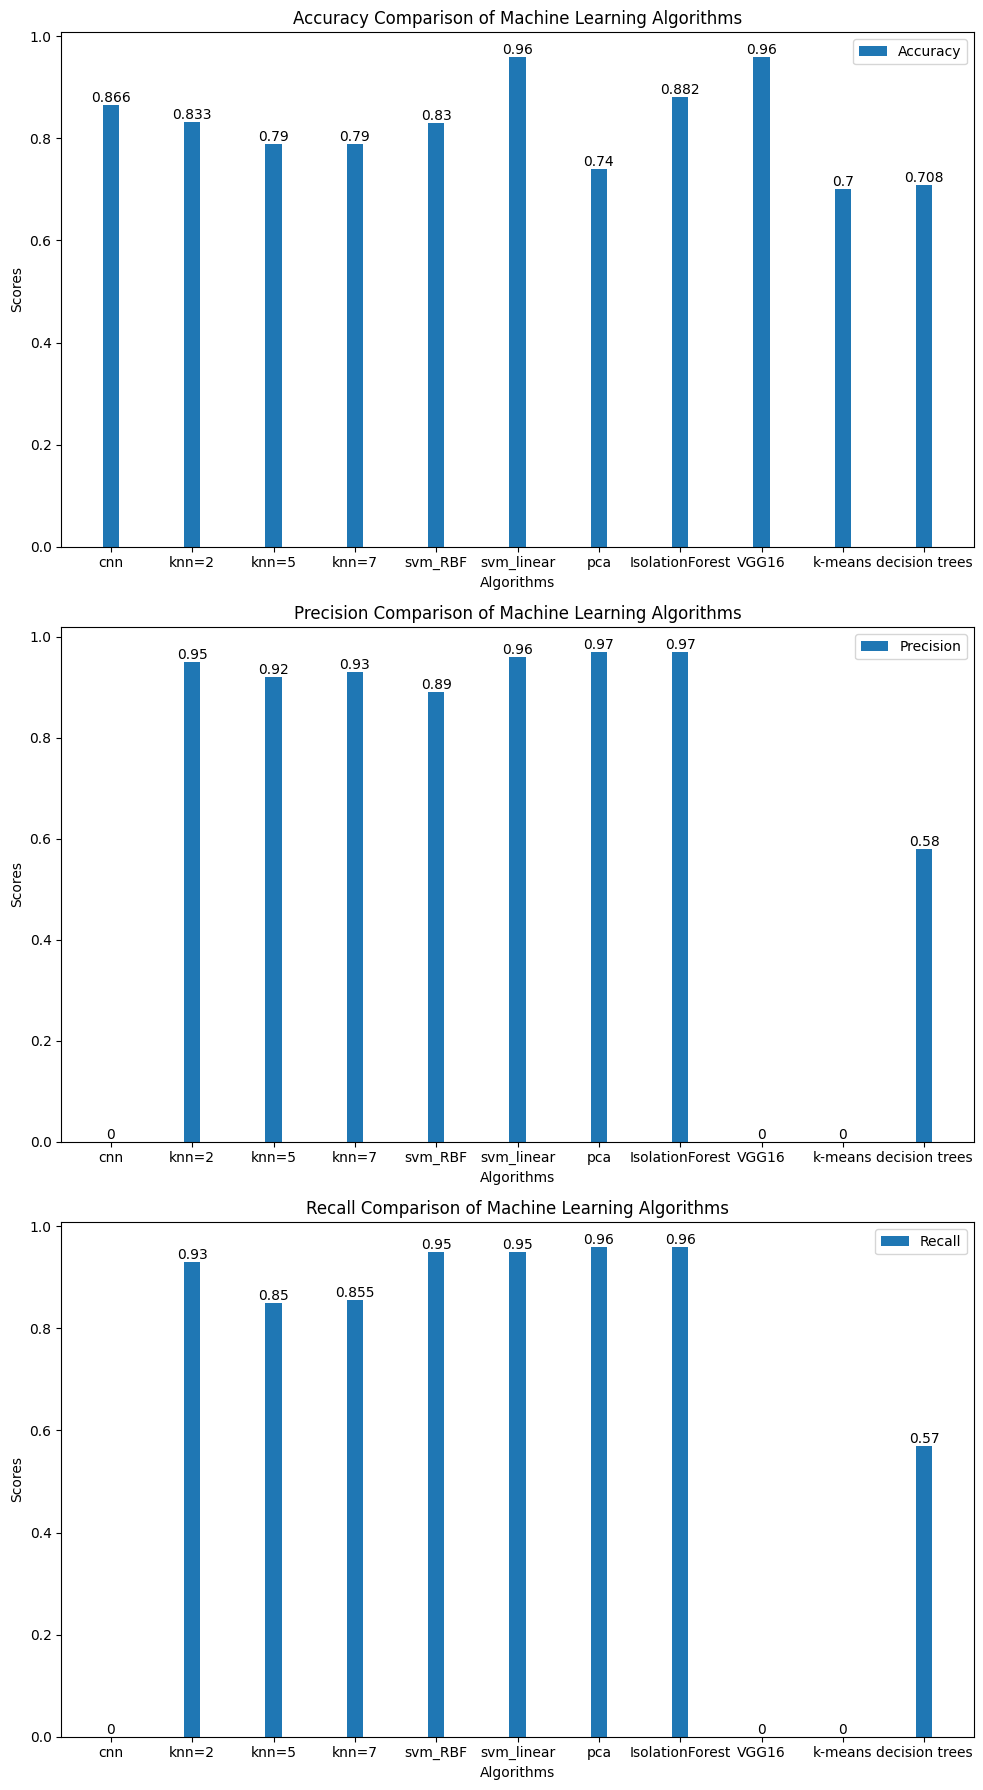

In [52]:

# Step 3: Prepare the data
algorithms = ['cnn', 'knn=2', 'knn=5', 'knn=7', 'svm_RBF', 'svm_linear', 'pca', 'IsolationForest', 'VGG16', 'k-means', 'decision trees']
accuracy_scores = [0.866, 0.833, 0.79, 0.79, 0.83, 0.96, 0.74, 0.882, 0.96, 0.70, 0.708]
precision_scores = [0, 0.95, 0.92, 0.93, 0.89, 0.96, 0.97, 0.97, 0, 0, 0.58]
recall_scores = [0, 0.93, 0.85, 0.855, 0.95, 0.95, 0.96, 0.96, 0, 0, 0.57]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))  # Adjust the figure size as per your preference

# Step 5: Plot the data
x_pos = np.arange(len(algorithms))
bar_width = 0.2  # Adjust the width of the bars as per your preference

axes[0].bar(x_pos, accuracy_scores, width=bar_width, label='Accuracy')
axes[1].bar(x_pos, precision_scores, width=bar_width, label='Precision')
axes[2].bar(x_pos, recall_scores, width=bar_width, label='Recall')

# Step 6: Add labels and legends
for i in range(len(algorithms)):
    axes[0].text(x_pos[i], accuracy_scores[i], str(accuracy_scores[i]), ha='center', va='bottom')
    axes[1].text(x_pos[i], precision_scores[i], str(precision_scores[i]), ha='center', va='bottom')
    axes[2].text(x_pos[i], recall_scores[i], str(recall_scores[i]), ha='center', va='bottom')

axes[0].legend()
axes[1].legend()
axes[2].legend()

# Step 7: Customize the charts
axes[0].set_title('Accuracy Comparison of Machine Learning Algorithms')
axes[1].set_title('Precision Comparison of Machine Learning Algorithms')
axes[2].set_title('Recall Comparison of Machine Learning Algorithms')

for ax in axes:
    ax.set_xticks(x_pos)
    ax.set_xticklabels(algorithms)
    ax.set_xlabel('Algorithms')
    ax.set_ylabel('Scores')

# Step 8: Display or save the charts
plt.tight_layout()
plt.show()
